## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo III - Arquiteturas de CNNS e treinamento de redes profundas</span>


### <span style="color:darkred">Avaliação</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

As respostas devem ser dadas no Moodle, use esse notebook apenas para gerar o código necessário para obter as respostas

---

---
### Questão 1)

Quais das alternativas abaixo compõe pontos fundamentais na prática para o projeto viável de treinamento de redes profundas?

(a) Conhecer os valores possíveis da função de perda utilizada, buscando por taxas de aprendizado e batchsizes adequados ao otimizador utilizando pequenos conjuntos de treinamento e validação.<br>
(b) Utilizar o maior número de instancias disponível para executar experimentos exaustivos com relação a função de custo, taxa de aprendizado, outros hiperparâmetros e escolhas como: momentum, decaimento de taxa de aprendizado, tamanho do batch, em como o otimizador utilizado.<br>
(c) Utilizar os valores padrão disponíveis nos pacotes de software para aprendizado de máquina, investigando diferentes arquiteturas de rede neural populares na literatura, até encontrar aquela que gera o melhor resultado no conjunto de testes<br>
(d) Inicializar sempre os pesos com valores aleatórios é suficiente para garantir a viabilidade do treinamento.<br>

---
### Questão 2)

Funções de perda diferentes geram intervalos de valores diferentes para um mesmo problema. Qual a consequência de uma função escolhida gerar valores muito pequenos durante o treinamento?

 (a) Facilita o treinamento gerando maior generalização do modelo final<br>
 (b) Problemas de precisão numérica e relacionados à baixa magnitude do gradiente<br>
 (c) Problemas relacionados à alta magnitude do gradiente e baixa generalização do modelo<br>
 (d) Podem ocorrer problemas de overfitting devido à convergência do modelo acontecer muito rapidamente<br>



---
### Questão 3)

Considere um problema cuja saída desejada seja um valor contínuo entre -20 e 10. Considerando que não há possibilidade de normalizar ou transformar esse intervalo, qual par função de ativação e qual função de perda são as mais adequadas para resolver esse problema?

(a) Ativação LeakyRelu e Perda Entropia Cruzada<br>
(b) Ativação Tangente Hiperbólica e Perda Quadrática<br>
(c) Ativação Relu e Perda Entropia Cruzada<br>
(d) Ativação Linear e Perda pelo Erro Absoluto Médio<br>

---
### Questão 4)

Carregue a base de dados Fashion-MNIST e projete uma rede do tipo ResNetInception utilizando os módulos Inception e Residuais conforme vistos em aula. A arquitetura deve ter, nessa ordem:
* Bloco Residual com 64 filtros
* Maxpooling com pool=2, stride=2
* Módulo Inception V1 com número de filtros: 32, 64, 64, 64, 64, 16
* Maxpooling com pool=2, stride=2
* GlobalAveragePooling2D

Além disso utilizar: otimizador Adam, com batchsize 32, e 5 épocas.

Investigue os seguintes valores de taxa de aprendizado: 0.001, 0.005, 0.01 e 0.05, todos com decaimento exponencial com valor 0.05

Treine por 5 épocas, utilizando as primeiras 1000 imagens (:1000) para treinamento e as próximas 1000 para validação (1000:2000).

Qual taxa de aprendizado teve maior acurácia na validação?

(a) 0.001<br>
(b) 0.005<br>
(c) 0.01<br>
(d) 0.05<br>

(60000, 28, 28)
Classes:  10


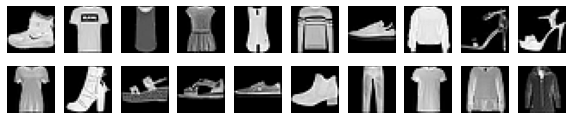

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_seed

from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

fig, axes = plt.subplots(2,10, figsize=(10,2))
ax = axes.ravel()
for i in range(20):
    ax[i].imshow(x_train[i], cmap="gray")
    ax[i].axis('off')
    
img_lin, img_col = x_train.shape[1], x_train.shape[2]
num_classes = len(np.unique(y_train))
print(x_train.shape)
print('Classes: ', num_classes)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# verifica se as imagens da base de dados tem um canal (i.e. em tons de cinza)
# ou mais do que um canal e se houver mais do que um canal entao armazena a
# quantidade de canais
if (len(x_train.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train.shape[3]

# re-formatando as imagens de forma que sejam transformadas em 
# matrizes com canais (por exemplo quando as imagens sao RGB)
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_lin, img_col)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train = x_train.reshape(x_train.shape[0], img_lin, img_col, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense


def inception_module(layer_in, f1_out, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1_out, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

def residual_block(layer_in, n_filters):
    merge_input = layer_in
    #verifica se é necessária uma primeira camada para deixar o número de filtros iguais para adição
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # soma entrada com saída (pulou 2 camadas)
    layer_out = add([conv2, merge_input])
    # função de ativação da saída do bloco
    layer_out = keras.layers.Activation('relu')(layer_out)
    return layer_out

In [5]:
#criando a rede inception
# # layer1 = inception_module(input_layer, 32, 32, 32, 32, 32, 16)

input_layer = Input(shape=input_shape)
# RESIDUAL DE 64
layer1 = residual_block(input_layer, 64)
# MAXPOOLING
pool1 = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer1)

# INCEPTION
layer2 = inception_module(pool1, 32, 64, 64, 64, 64, 16)

# MAXPOOLING
pool2 = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer2)
# GLOBALAVERAGEPOOLING 2D
flatt = GlobalAveragePooling2D()(pool2)
softmax = Dense(10, activation='softmax')(flatt)

Inception = tf.keras.models.Model(input_layer, outputs=softmax)
Inception.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   128         input_2[0][0]                    
_______________________________________________________________________________________

In [8]:
x_train_sub = x_train[:1000]
y_train_sub = y_train[:1000]

x_train_valid = x_train[1000:2000]
y_train_valid = y_train[1000:2000]

print(x_train_sub.shape)
print(y_train_sub.shape)

print(x_train_valid.shape)
print(y_train_valid.shape)

(1000, 28, 28, 1)
(1000, 10)
(1000, 28, 28, 1)
(1000, 10)


In [9]:
np.random.seed(1)
tf.random.set_seed(2)

lr = [0.001, 0.005, 0.01, 0.05]
InceptionResults = []

for learning_rate in lr:
    Inception.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

    Inception.fit(x_train_sub, y_train_sub,
                        batch_size=32,
                        epochs=5, verbose=1)

    InceptionResults.append(
            Inception.evaluate(x_train_valid, y_train_valid, verbose = 1))
    

Epoch 1/5
32/32 [==============================] - 1s 28ms/step - loss: 2.1154 - accuracy: 0.2640
Epoch 2/5
32/32 [==============================] - 1s 16ms/step - loss: 1.4028 - accuracy: 0.4810
Epoch 3/5
32/32 [==============================] - 1s 16ms/step - loss: 1.1161 - accuracy: 0.5950
Epoch 4/5
32/32 [==============================] - 1s 16ms/step - loss: 0.9628 - accuracy: 0.6740
Epoch 5/5
32/32 [==============================] - 0s 8ms/step - loss: 0.7789 - accuracy: 0.7350
Epoch 1/5
32/32 [==============================] - 0s 15ms/step - loss: 2.2998 - accuracy: 0.4340
Epoch 2/5
32/32 [==============================] - 0s 15ms/step - loss: 1.0486 - accuracy: 0.6350
Epoch 3/5
32/32 [==============================] - 0s 15ms/step - loss: 0.8479 - accuracy: 0.7110
Epoch 4/5
32/32 [==============================] - 0s 15ms/step - loss: 0.7942 - accuracy: 0.7320
Epoch 5/5
32/32 [==============================] - 0s 7ms/step - loss: 0.7357 - accuracy: 0.7560
Epoch 1/5
32/32 [=====

In [14]:
for i in range(4):
    print("Inception Treinamento = Loss %.3f, Accuracy %.3f" % (InceptionResults[i][0], InceptionResults[i][1]))

Inception Treinamento = Loss 0.779, Accuracy 0.735
Inception Treinamento = Loss 0.736, Accuracy 0.756
Inception Treinamento = Loss 0.682, Accuracy 0.779
Inception Treinamento = Loss 1.360, Accuracy 0.440


---

### Questão 5)

Considere as situações abaixo listadas, observadas de forma independente após treinar modelos de rede profunda por 50 épocas para um problema de classificação com 20 classes usando a perda quadrática:

I - O valor da perda convergiu para um valor próximo a zero<br>
II - O valor da perda após a primeira época foi de 2.61<br>
III - A acurácia final medida no treinamento foi de 65% e na validação de 68%<br>
IV - O valor da perda caiu de 0.90 na primeira época para 0.72 na última época<br>

OBS: para interpretar os valores acima, calcule a perda quadrática e a acurácia para os seguintes cenários de vetores de probabilidade de saída (para 20 classes): todas as classes equiprováveis (aleatório uniformemente distribuído), e de um vetor de saída com a classe correta, porém com baixa probabilidade, com 0.2 para a classe correta, mas que possui outros 8 valores com 0.1.

Quais das situações acima estão tipicamente ligadas a problemas no cálculo do gradiente (causado muitas vezes por escolhas erradas na arquitetura e função e custo) e/ou na convergência do modelo causados por escolhas erradas do otimizador e seus hiper-parâmetros?

(a) Todos<br>
(b) II e IV<br>
(c) I e II<br>
(d) III e IV<br>

In [20]:
y = np.random.uniform(0, 1, 20)
y

array([0.80074457, 0.96826158, 0.31342418, 0.69232262, 0.87638915,
       0.89460666, 0.08504421, 0.03905478, 0.16983042, 0.8781425 ,
       0.09834683, 0.42110763, 0.95788953, 0.53316528, 0.69187711,
       0.31551563, 0.68650093, 0.83462567, 0.01828828, 0.75014431])

In [22]:
yh = np.random.uniform(0, 1, 20)
yh


array([0.98886109, 0.74816565, 0.28044399, 0.78927933, 0.10322601,
       0.44789353, 0.9085955 , 0.29361415, 0.28777534, 0.13002857,
       0.01936696, 0.67883553, 0.21162812, 0.26554666, 0.49157316,
       0.05336255, 0.57411761, 0.14672857, 0.58930554, 0.69975836])

In [23]:
quadratic_loss = (y-y_hat)**2
print(f'Media: {np.mean(quadratic_loss):.3f}')
quadratic_loss

Media: 0.228


array([0.64119186, 0.83837829, 0.04333101, 0.28561316, 0.44337332,
       0.39872755, 0.05324338, 0.10848214, 0.0631126 , 0.16358651,
       0.18315743, 0.02491338, 0.1064786 , 0.02281466, 0.00202185,
       0.22463624, 0.02421271, 0.00361335, 0.86318991, 0.06242786])